In [441]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.svm import SVC

# Additional imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score , confusion_matrix , classification_report
from sklearn.model_selection import GridSearchCV, cross_validate

In [442]:
df = pd.read_excel("churn_prediction.xlsx")

In [443]:
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [444]:
df.shape

(5630, 20)

In [445]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [446]:
df.nunique()

CustomerID                     5630
Churn                             2
Tenure                           36
PreferredLoginDevice              3
CityTier                          3
WarehouseToHome                  34
PreferredPaymentMode              7
Gender                            2
HourSpendOnApp                    6
NumberOfDeviceRegistered          6
PreferedOrderCat                  6
SatisfactionScore                 5
MaritalStatus                     3
NumberOfAddress                  15
Complain                          2
OrderAmountHikeFromlastYear      16
CouponUsed                       17
OrderCount                       16
DaySinceLastOrder                22
CashbackAmount                 2586
dtype: int64

### Features

In [447]:
df.columns.to_list()

['CustomerID',
 'Churn',
 'Tenure',
 'PreferredLoginDevice',
 'CityTier',
 'WarehouseToHome',
 'PreferredPaymentMode',
 'Gender',
 'HourSpendOnApp',
 'NumberOfDeviceRegistered',
 'PreferedOrderCat',
 'SatisfactionScore',
 'MaritalStatus',
 'NumberOfAddress',
 'Complain',
 'OrderAmountHikeFromlastYear',
 'CouponUsed',
 'OrderCount',
 'DaySinceLastOrder',
 'CashbackAmount']

In [448]:
#exclude numeric columns, keep other columns
cat_cols=df.select_dtypes(exclude=np.number).columns.tolist()
#numeric columns
num_cols=df.select_dtypes(include=np.number).columns.tolist()

In [449]:
#As mobile phone and phone are both same so we have merged them
df.loc[df['PreferredLoginDevice'] == 'Phone', 'PreferredLoginDevice' ] = 'Mobile Phone'
df.loc[df['PreferedOrderCat'] == 'Mobile', 'PreferedOrderCat' ] = 'Mobile Phone'
#as cod is also cash on delievery
#as cc is also credit card so i merged them
df.loc[df['PreferredPaymentMode'] == 'COD', 'PreferredPaymentMode' ] = 'Cash on Delivery'   # uses loc function
df.loc[df['PreferredPaymentMode'] == 'CC', 'PreferredPaymentMode' ] = 'Credit Card'

## Overview EDA

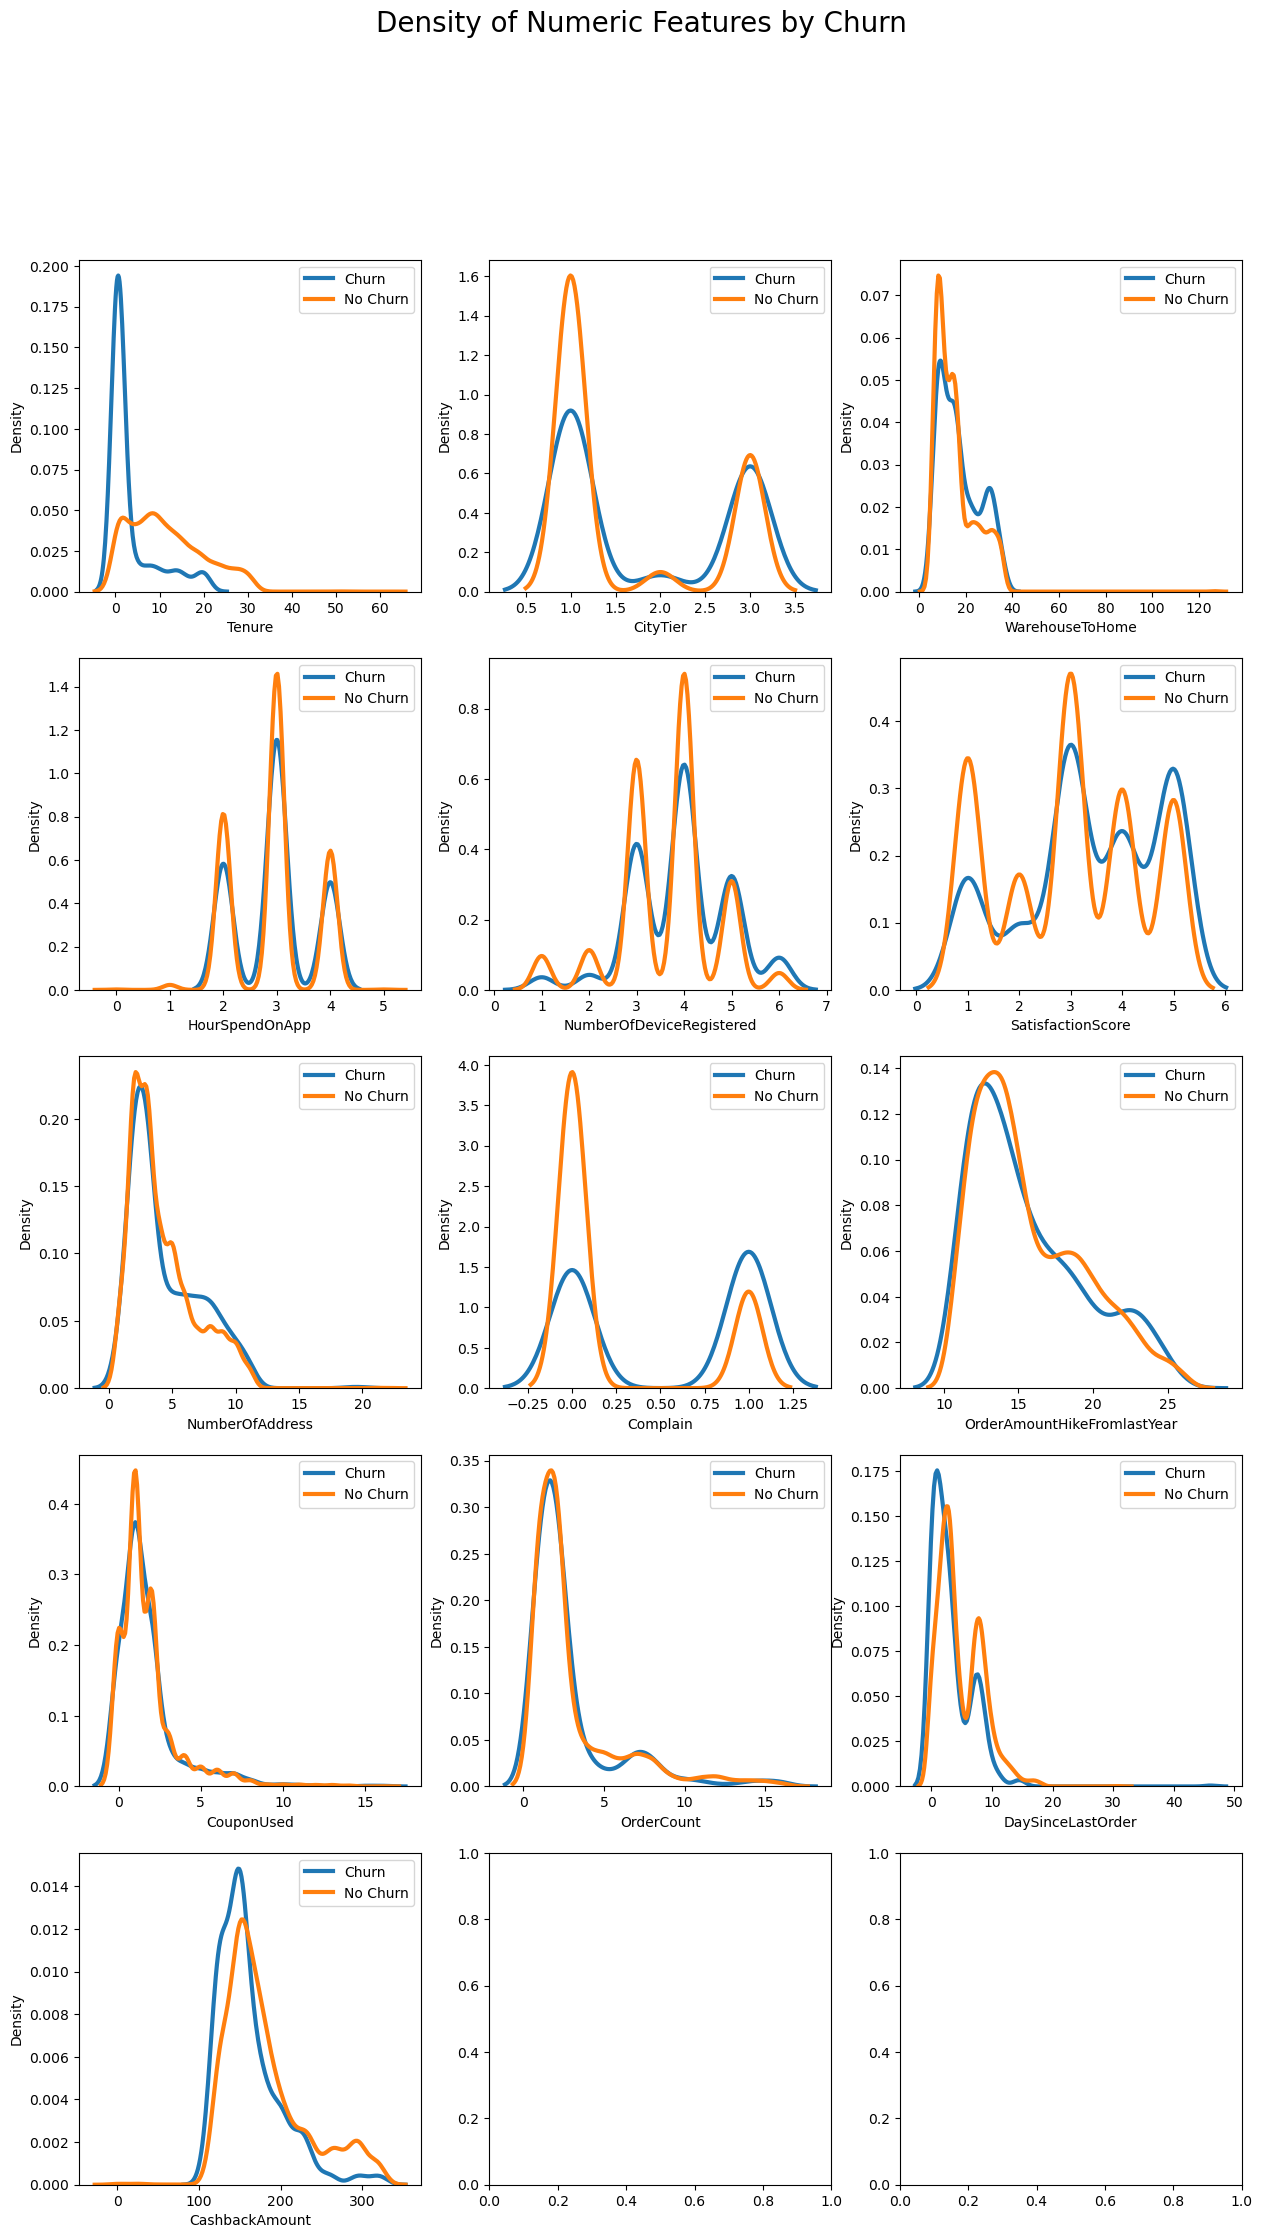

In [450]:
label_col=df['Churn']
num_cols.remove('CustomerID')
num_cols.remove('Churn')

df_churn = df[df['Churn']==1].copy()
df_notchurn = df[df['Churn']==0].copy()

fig, ax = plt.subplots(5,3,figsize=(15, 25))
fig.suptitle('Density of Numeric Features by Churn', fontsize=20)
ax = ax.flatten()

for idx,c in enumerate(num_cols):
    sns.kdeplot(df_churn[c], linewidth= 3,
             label = 'Churn',ax=ax[idx])
    sns.kdeplot(df_notchurn[c], linewidth= 3,
             label = 'No Churn',ax=ax[idx])

    ax[idx].legend(loc='upper right')

plt.show()

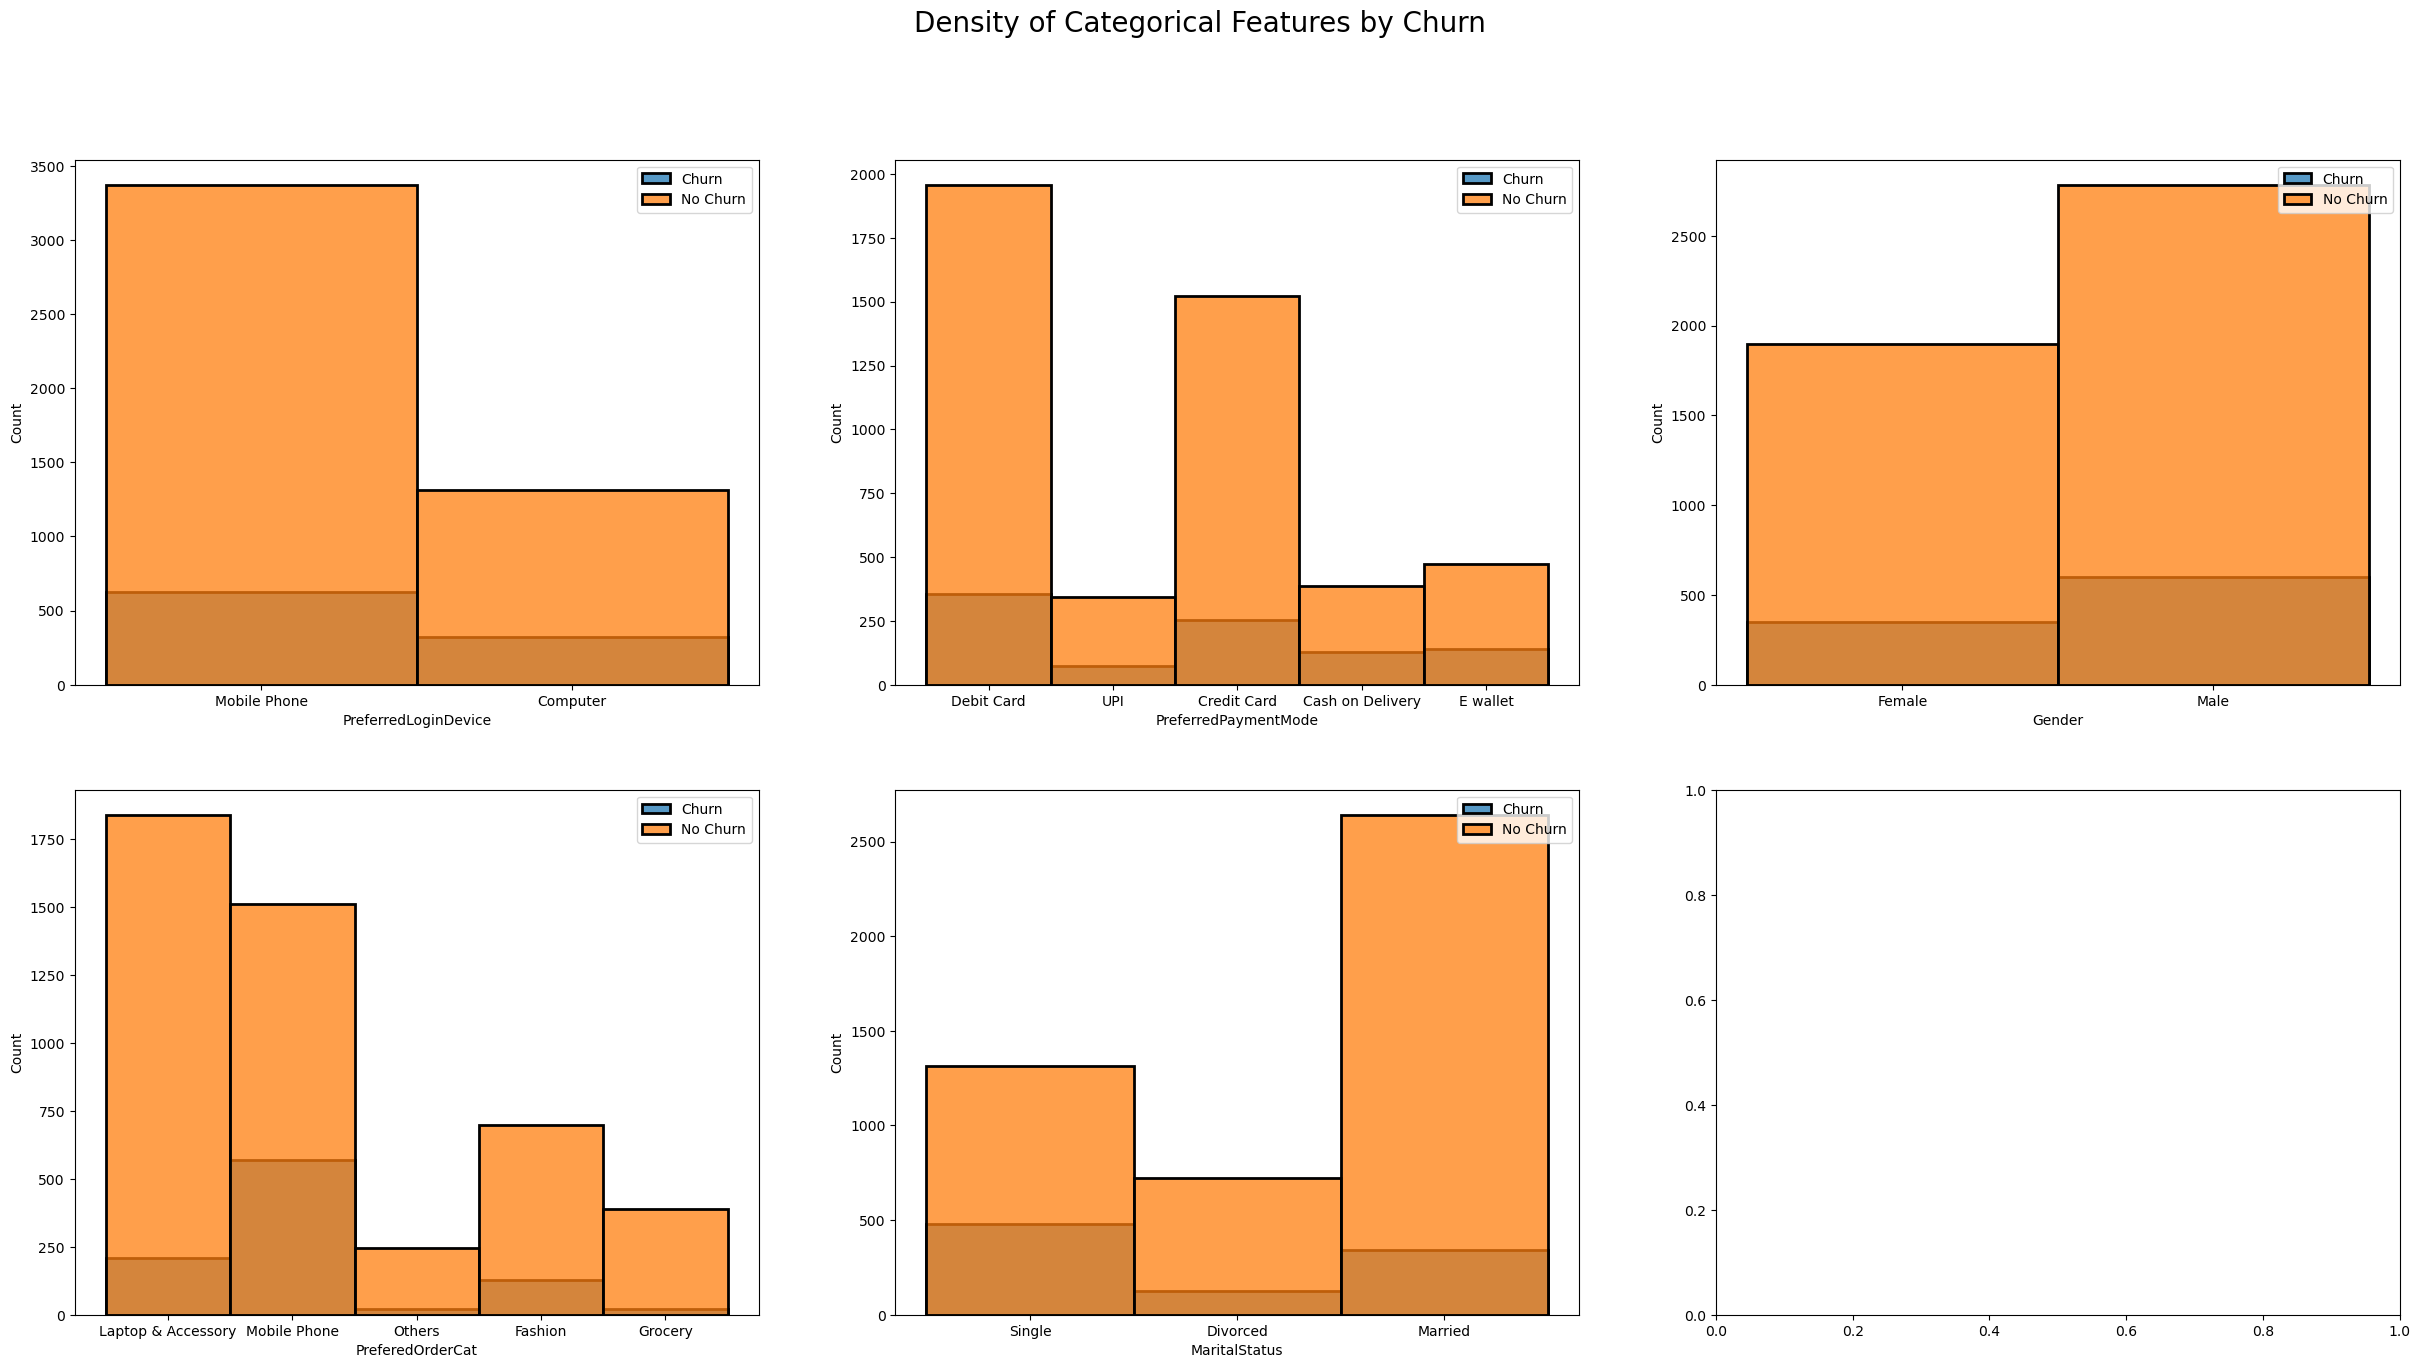

In [451]:
fig, ax = plt.subplots(2,3,figsize=(30, 15))
fig.suptitle('Density of Categorical Features by Churn', fontsize=20)
ax = ax.flatten()

for idx,c in enumerate(cat_cols):
    sns.histplot(df_churn[c], linewidth= 2,
             label = 'Churn',ax=ax[idx])
    sns.histplot(df_notchurn[c], linewidth= 2,
             label = 'No Churn',ax=ax[idx])

    ax[idx].legend(loc='upper right')
    ax[idx].tick_params(axis='x', rotation=0
                        )


plt.show()

### Distributions Insights

<li> Customers with longer tenure is less likely to churn.
<li> All of churn and not churn customers is located in city 1 and city 3. This does not to be seemed as a prediction of churn.
<li> Shorter WarehouseToHome distances have lower churn rate. 
<li> Most customers spend 2-4 hours on app.
<li> More number of devices registered associated with lower churn. More devices may increases convenience.
<li> Lower satisfaction scores relate to lower churn.
<li> There are slightly lower churn since number of addresses increases. More addresses increase loyalty.
<li> Customers who complain seems to churn more than customers do not complain.
<li> The churn rate of customers who have high increase orders than last year decreases.
<li> Coupons increase correlate with lower churn.
<li> More odercounts mean less likely to churn. Frequent usage build habits.
<li> Longer DaySinceLastOrder means higher churn rate. 
<li> More cashbackamount indicates that customers is less likely to churn.

## EDA

### Relationship between Gender and Churn

In [452]:
GC = df['Gender'].value_counts().reset_index()
GC['Percentage']=round(GC['Gender']/sum(GC['Gender'])*100,2)
GC

,index,Gender,Percentage
0,Male,3384,60.11
1,Female,2246,39.89


In [453]:
df.groupby(["Churn"])['Gender'].value_counts()

Churn  Gender
0      Male      2784
       Female    1898
1      Male       600
       Female     348
Name: Gender, dtype: int64

In [454]:
#Percentage of churned males and churned females
print('Percentage of churned males:', round(600/3384*100,2))
print('Percentage of churned females:', round(348/2246*100,2))

Percentage of churned males: 17.73
Percentage of churned females: 15.49


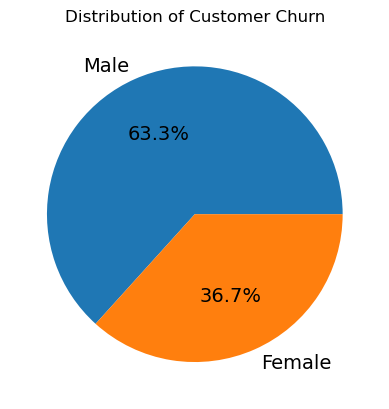

In [455]:
x= df_churn['Gender'].value_counts()
plt.title('Distribution of Customer Churn')
plt.pie(x,labels=x.index,autopct='%1.1f%%',textprops={'fontsize':14})
plt.show()

As we see, males are more likely to churn. The app may be consider analyzing the products grap for males. We are still going to see if there are other factors 

### Which MartialStatus has the highest Churn rate?

Text(0.5, 1.0, 'Churn Rates by MaritalStatus')

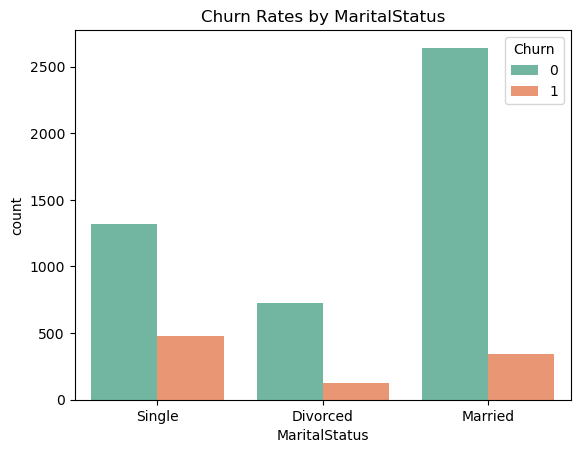

In [456]:
sns.countplot(x='MaritalStatus',hue='Churn',data=df,palette='Set2')
plt.title("Churn Rates by MaritalStatus")

As in the plot, Married customers are the highest. The company should take care of single and married people since singles and marriers acount for the most in churn customers.

### Which CityTier has higher Tenure and OrderCount

In [457]:
df_tenure=df.groupby('CityTier')['Tenure'].agg(['mean','max'])
df_tenure

,mean,max
CityTier,,
1,10.528818,51.0
2,11.169725,31.0
3,9.361740,61.0


In [458]:
df_order = df.groupby('CityTier')['OrderCount'].agg(['mean', 'max'])
df_order

,mean,max
CityTier,,
1,2.953255,16.0
2,2.584034,13.0
3,3.185185,16.0


city 2 has highest average tenure, city 3 has the highest ordercount, so tenure and ordercount seem not to relate to each other.

### High SatisfactionScore => High HourSpendOnApp ?

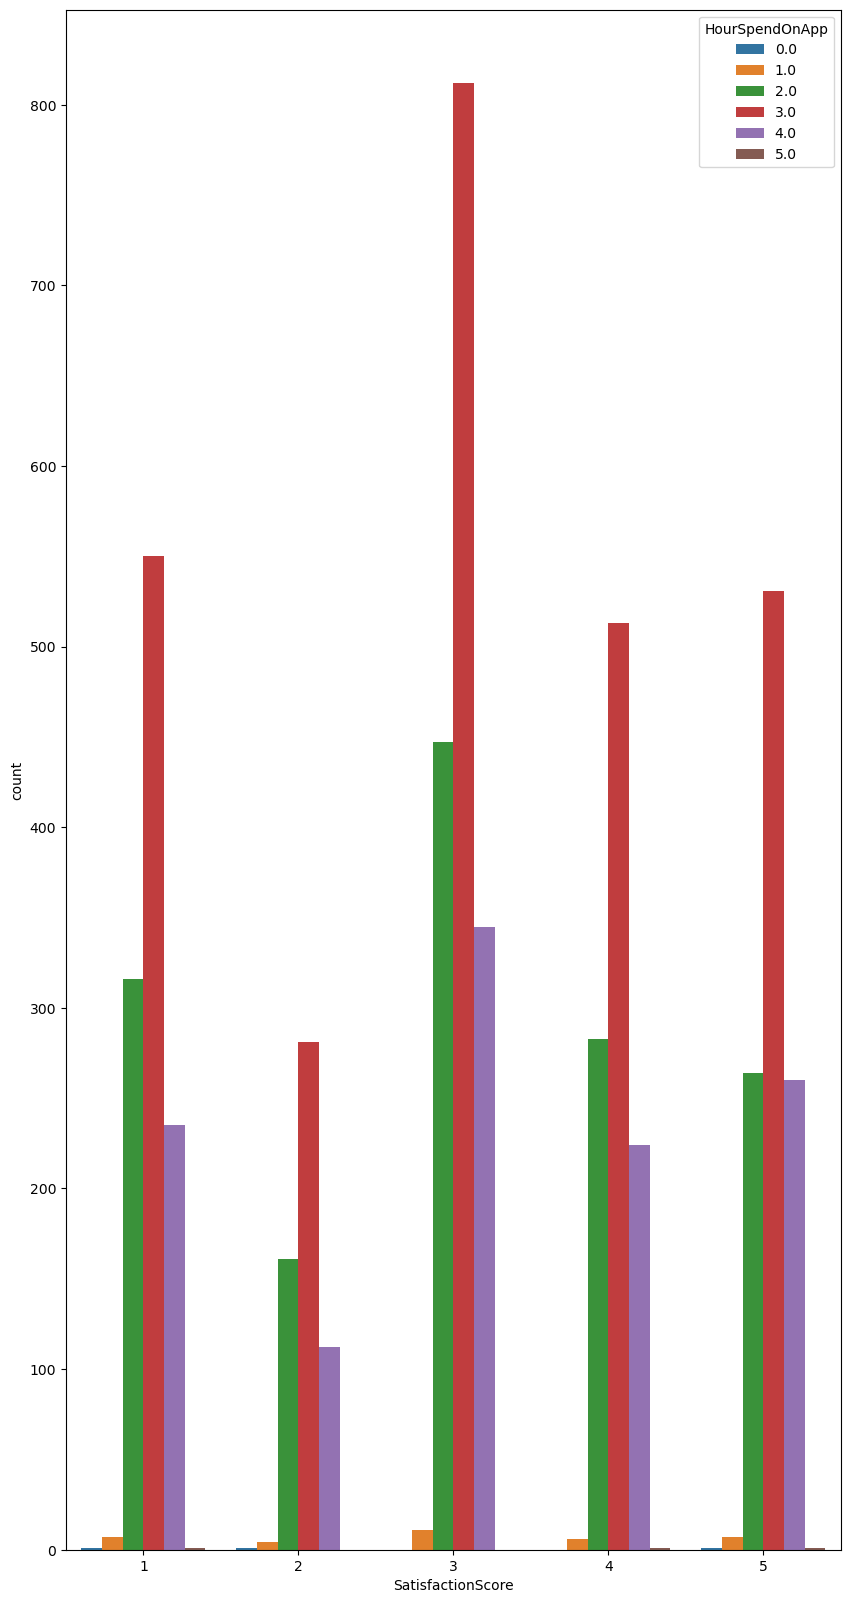

In [459]:
plt.figure(figsize=(10,20))
ax=sns.countplot(data=df,x='SatisfactionScore',hue='HourSpendOnApp')


We can see that in every score, customers who spend 3 hours are the highest. But I do not think there is any relation between the satisfaction score and HourSpendOnApp.

### Which CityTier has the most HourSpendOnApp?

c:\Users\admin\.conda\envs\dungx\lib\site-packages\seaborn\axisgrid.py:848: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


c:\Users\admin\.conda\envs\dungx\lib\site-packages\seaborn\axisgrid.py:848: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


c:\Users\admin\.conda\envs\dungx\lib\site-packages\seaborn\axisgrid.py:848: Us

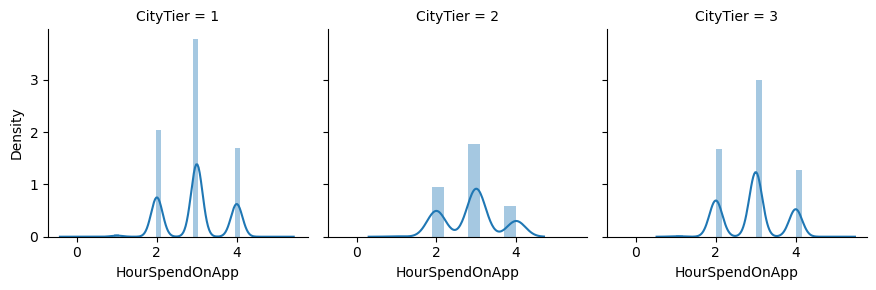

In [460]:
g = sns.FacetGrid(df, col='CityTier')
g.map(sns.distplot, 'HourSpendOnApp')

City tier 1 has the most spended hours on app.

### Relation between NumberOfAddress and CityTier within the churn segment?

<AxesSubplot:xlabel='CityTier', ylabel='NumberOfAddress'>

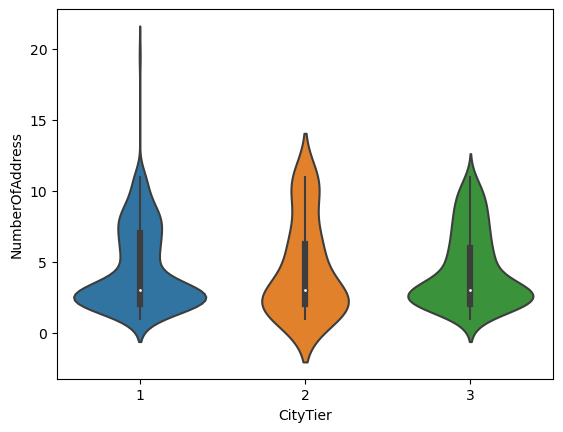

In [461]:

import seaborn as sns
sns.violinplot(x='CityTier', y='NumberOfAddress', data=df[df['Churn']==1])

We can see that smaller CityTier means fewer number of address. Customers in city tier 1 tends to have more address on average. This relationship suggests there are differences in density and type of cities, these impacts on how many addresses a customer has.

### What is the relation between Complain and DaySinceLastOrder?

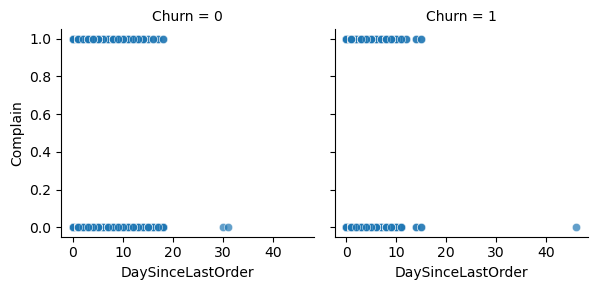

In [462]:
g = sns.FacetGrid(df, col='Churn')
g.map(sns.scatterplot, 'DaySinceLastOrder', 'Complain', alpha=.7)
g.add_legend()

I think there is a weak relationship between complains and DaySinceLastOrder. 

### Is there a relationship between PreferredLoginDevice and churn?

<AxesSubplot:xlabel='PreferredLoginDevice', ylabel='count'>

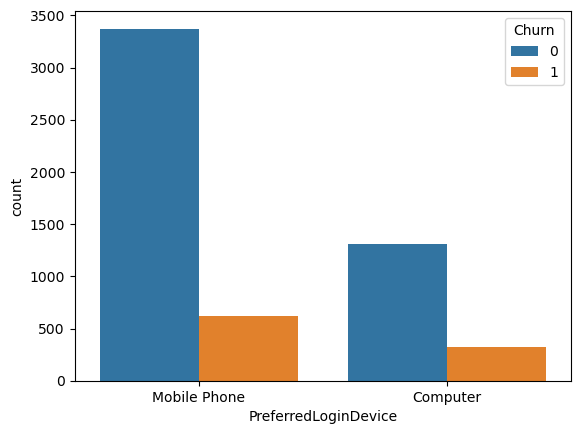

In [463]:
sns.countplot(x=df['PreferredLoginDevice'],hue=df['Churn'])

Mobile Phone users are likely to churn, this may indicate a problem on app user experience on mobile version.

### Distribution of WarehouseToHome distance and CityTier ?


<AxesSubplot:xlabel='CityTier', ylabel='WarehouseToHome'>

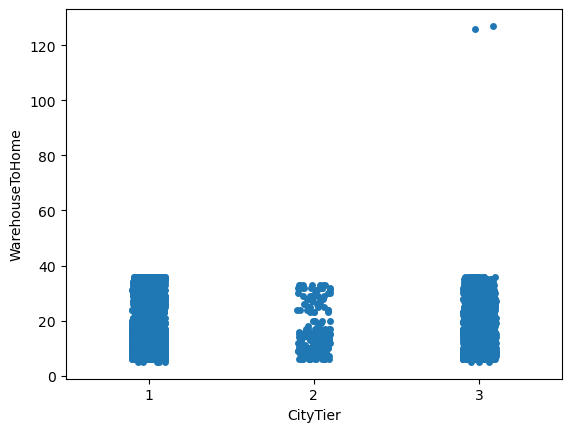

In [464]:
sns.stripplot(data=df,x='CityTier',y='WarehouseToHome',jitter=True)

The distances between warehouse and customer homes is similar in all cities.

### Does different citytiers has different prefered products

In [465]:
import plotly.express as px
# earth_palette = ["#A67C52", "#8F704D", "#B09B71", "#7E786E"]
px.histogram(df,x="PreferedOrderCat",facet_col="CityTier",color="CityTier",text_auto= True , title="<b>"+'CityTier Vs PreferedOrderCat')

Laptop & Accessories and Mobile Phone are the most prefered products in every city.

### What is the preferred payment mode for different CityTiers

In [466]:
# g = sns.FacetGrid(df, col='CityTier')
# g.map(sns.countplot, 'PreferredPaymentMode')
# for axes in g.axes.flat:
#     _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

px.histogram(df,x="PreferredPaymentMode",facet_col="CityTier",color="CityTier",text_auto= True , title="<b>"+'CityTier Vs PaymentMethod')


Differences payment method for 3 cities:
<li> City tier 1: debit and credit card
<li> City tier 2: UPI
<li> City tier 3: E wallet and debit card

### Which CityTier has the highest OrderCount?

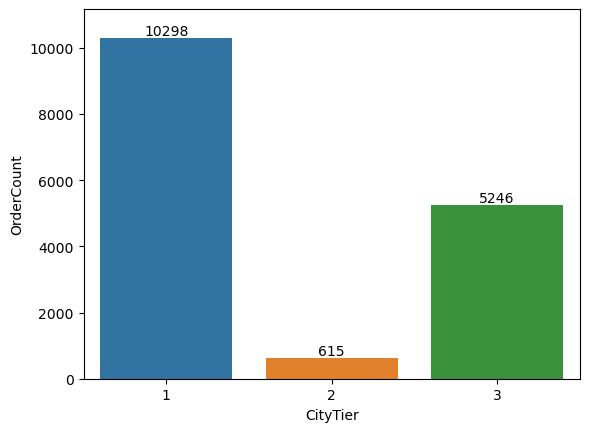

In [467]:
ax=sns.barplot(df, x="CityTier", y="OrderCount",estimator='sum',errwidth=0)
for i in ax.containers:
    ax.bar_label(i,)

City 1 has the highest orders with 10298 orders.

### Does OrderAmountHikeFromlastYear affect churn rate?

In [468]:
df_o=df.groupby(['OrderAmountHikeFromlastYear','Churn']).size().reset_index(name="Count")
df_o

,OrderAmountHikeFromlastYear,Churn,Count
0,11.0,0,309
1,11.0,1,82
2,12.0,0,584
3,12.0,1,144
4,13.0,0,613
5,13.0,1,128
6,14.0,0,634
7,14.0,1,116
8,15.0,0,460
9,15.0,1,82


<AxesSubplot:xlabel='OrderAmountHikeFromlastYear', ylabel='Count'>

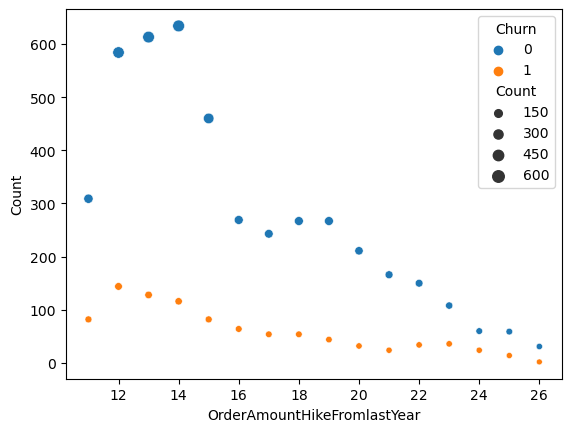

In [469]:
sns.scatterplot(data=df_o, x="OrderAmountHikeFromlastYear", y="Count",size='Count', hue="Churn")

After calculating, when OrderAmountHikeFromlastYear increases, the churn rate decreases. This is negetive effect. Through this plot, we need to focus on customers who has OrderAmountHikeFromlastYear between 12 and 14%.

### What is the relation between Complain and DaySinceLastOrder for churned customers?


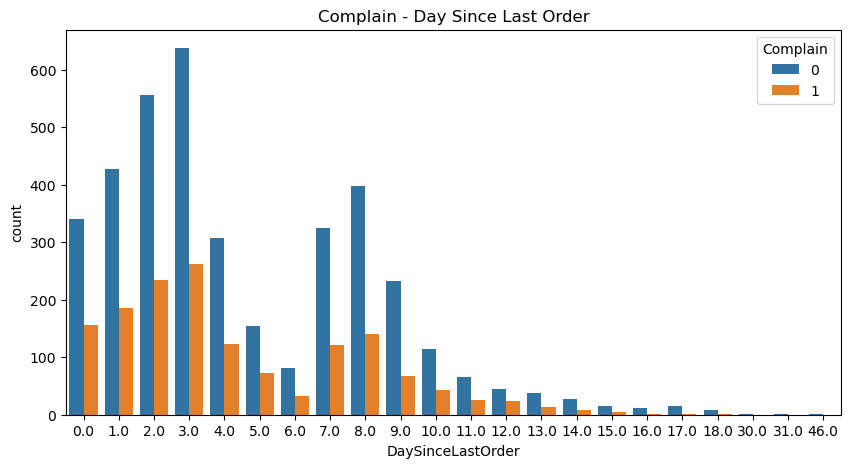

In [470]:
plt.figure(figsize=(10,5))
sns.countplot(x=df['DaySinceLastOrder'], hue=df['Complain'])
plt.title('Complain - Day Since Last Order')
plt.show()

Customers with no complains have longer DaySinceLastOrder.

### What is the order counts for customers with high HourSpendOnApp?


In [471]:
df2=df.copy()
bins=[0,1,3,6]
label=['low','medium','high']
df2['HSOA_bins']=pd.cut(df2['HourSpendOnApp'],bins=bins,labels=label)
df2.groupby(['HSOA_bins','OrderCount'])['CustomerID'].count()

HSOA_bins  OrderCount
low        1.0             16
           2.0              7
           3.0              1
           4.0              3
           5.0              0
           6.0              0
           7.0              4
           8.0              0
           9.0              0
           10.0             0
           11.0             1
           12.0             1
           13.0             0
           14.0             0
           15.0             0
           16.0             0
medium     1.0           1553
           2.0           1242
           3.0            267
           4.0            160
           5.0            130
           6.0            105
           7.0            169
           8.0             99
           9.0             53
           10.0            21
           11.0            46
           12.0            36
           13.0            24
           14.0            34
           15.0            21
           16.0            13
high       1.0    

In [472]:
# pip install --upgrade nbformat

In [473]:
df2_nomissing=df2.loc[:,['HSOA_bins','OrderCount']].dropna()
fig=px.sunburst(df2_nomissing,path=['HSOA_bins','OrderCount'],title="<b>"+'HourSpendOnApp VS OrderCount',template="plotly" )
fig.update_traces(textinfo="label+percent parent")
fig.show()


In segment medium and high HourSpendOnApp, customers who buy 1 and 2 times accounts for the most, 70% and 67% sequentially.

###  Relationship between preferred order category and Gender?

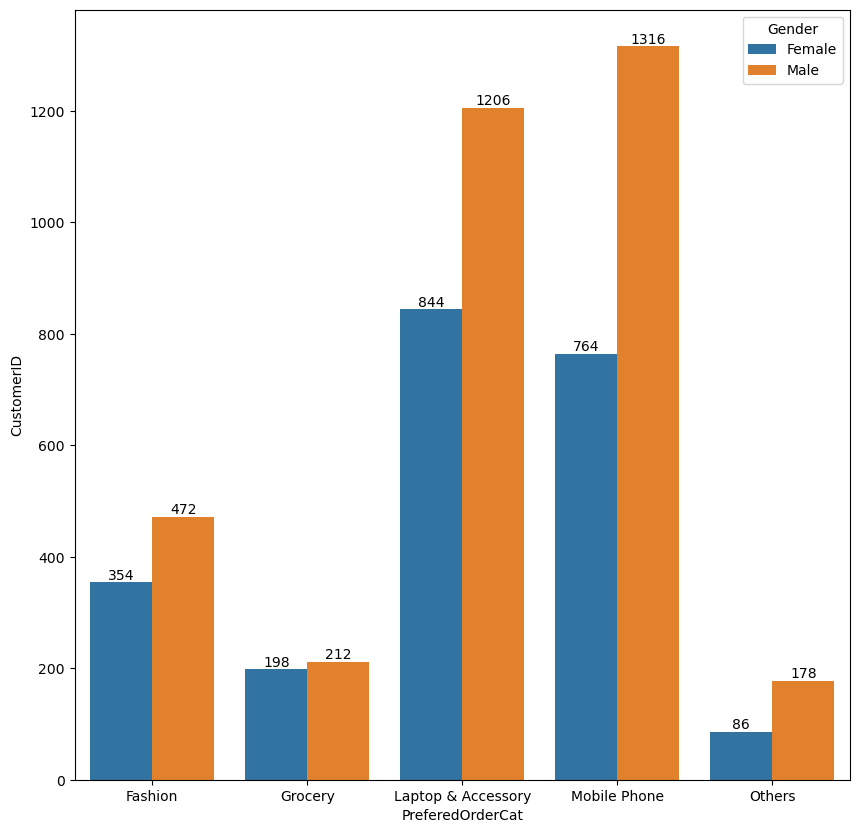

In [474]:
plt.figure(figsize=(10,10))
df3= df.groupby(['PreferedOrderCat' , 'Gender'])[['CustomerID']].count().reset_index()
ax=sns.barplot(data=df3,x='PreferedOrderCat',y='CustomerID',hue='Gender')
for i in ax.containers:
    ax.bar_label(i,)

Both males and females interest most in Laptop & Accessories and Mobile Phone.

Fashion and Grocery has the percentage of males and females with no large differences.

### Do customers who used more coupons have lower churn rates

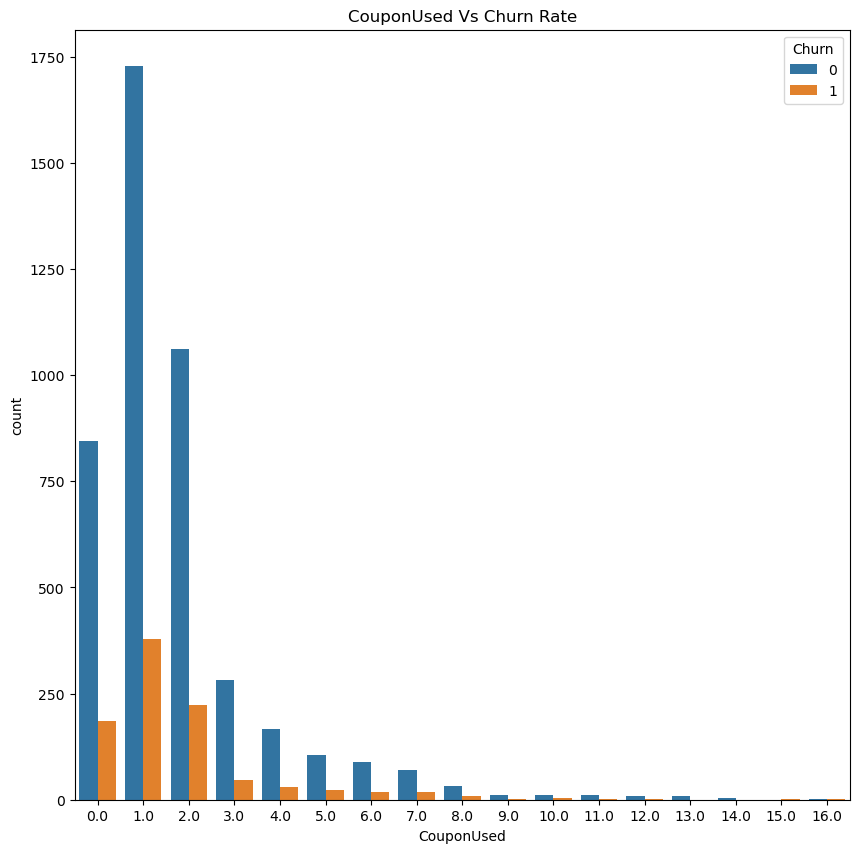

In [475]:
plt.figure(figsize=(10,10))
sns.countplot(data=df,x='CouponUsed',hue='Churn')
plt.title('CouponUsed Vs Churn Rate')
plt.show()

Churn become less when more coupons used.

### Is there a connection between satisfaction score and number of orders in the past month?

<AxesSubplot:xlabel='SatisfactionScore', ylabel='OrderCount'>

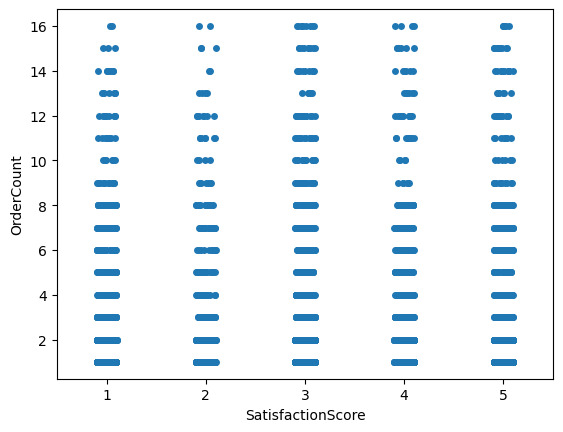

In [476]:
sns.stripplot(data=df, x="SatisfactionScore", y="OrderCount",jitter=True)

StatisfactionScore doesn't have affect on OrderCount.

### There is relation between CashbackAmount and order counts within churn?

<AxesSubplot:xlabel='OrderCount', ylabel='CashbackAmount'>

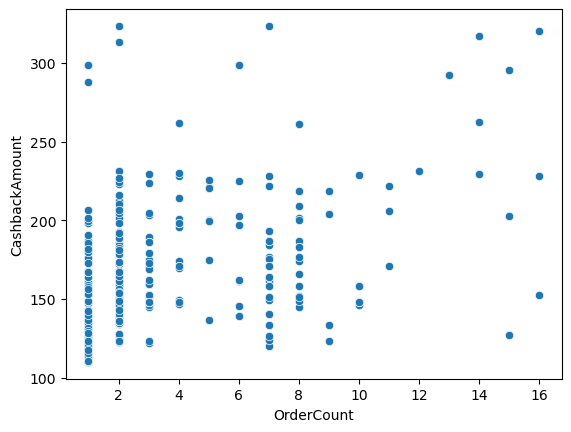

In [477]:
sns.scatterplot(data=df_churn, x="OrderCount",y='CashbackAmount')

There is no relationship between cash backamount and ordercount. There is positive relationship between cashbackamount and churn rate, positive relationship between ordercount and churn rate.

### Are customers who complained more likely to churn?

In [478]:
df4= df.groupby(['Complain','Churn']).size().reset_index()

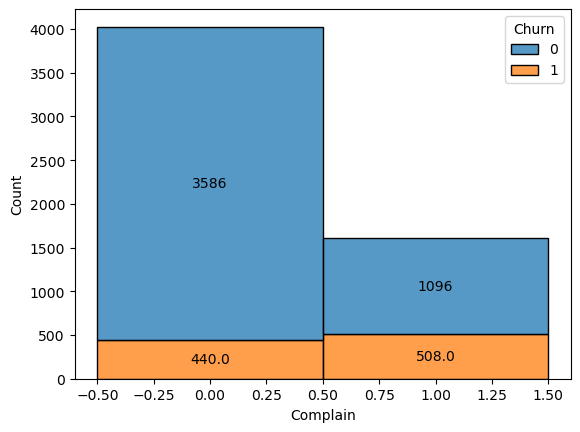

In [479]:
ax = sns.histplot(data=df4, x='Complain', hue='Churn', weights=0, discrete=True, multiple='stack')

# iterate through each container
for c in ax.containers:

    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center')


Customers who complain is likely to churn.

## Data Processing

### Check imbalanced data

In [480]:
check_bal=df['Churn'].value_counts().reset_index()
check_bal['Pecentage']=check_bal['Churn']/sum(check_bal['Churn'])*100
check_bal

,index,Churn,Pecentage
0,0,4682,83.161634
1,1,948,16.838366


Label 1 accounts for 17% of data. This is a quite imblanced data and we still can process ML model as normal.

### Handle values

#### Count the % of missing values in the dataset

In [481]:
round(df.isnull().sum()/df.shape[0]*100,2)

CustomerID                     0.00
Churn                          0.00
Tenure                         4.69
PreferredLoginDevice           0.00
CityTier                       0.00
WarehouseToHome                4.46
PreferredPaymentMode           0.00
Gender                         0.00
HourSpendOnApp                 4.53
NumberOfDeviceRegistered       0.00
PreferedOrderCat               0.00
SatisfactionScore              0.00
MaritalStatus                  0.00
NumberOfAddress                0.00
Complain                       0.00
OrderAmountHikeFromlastYear    4.71
CouponUsed                     4.55
OrderCount                     4.58
DaySinceLastOrder              5.45
CashbackAmount                 0.00
dtype: float64

<AxesSubplot:>

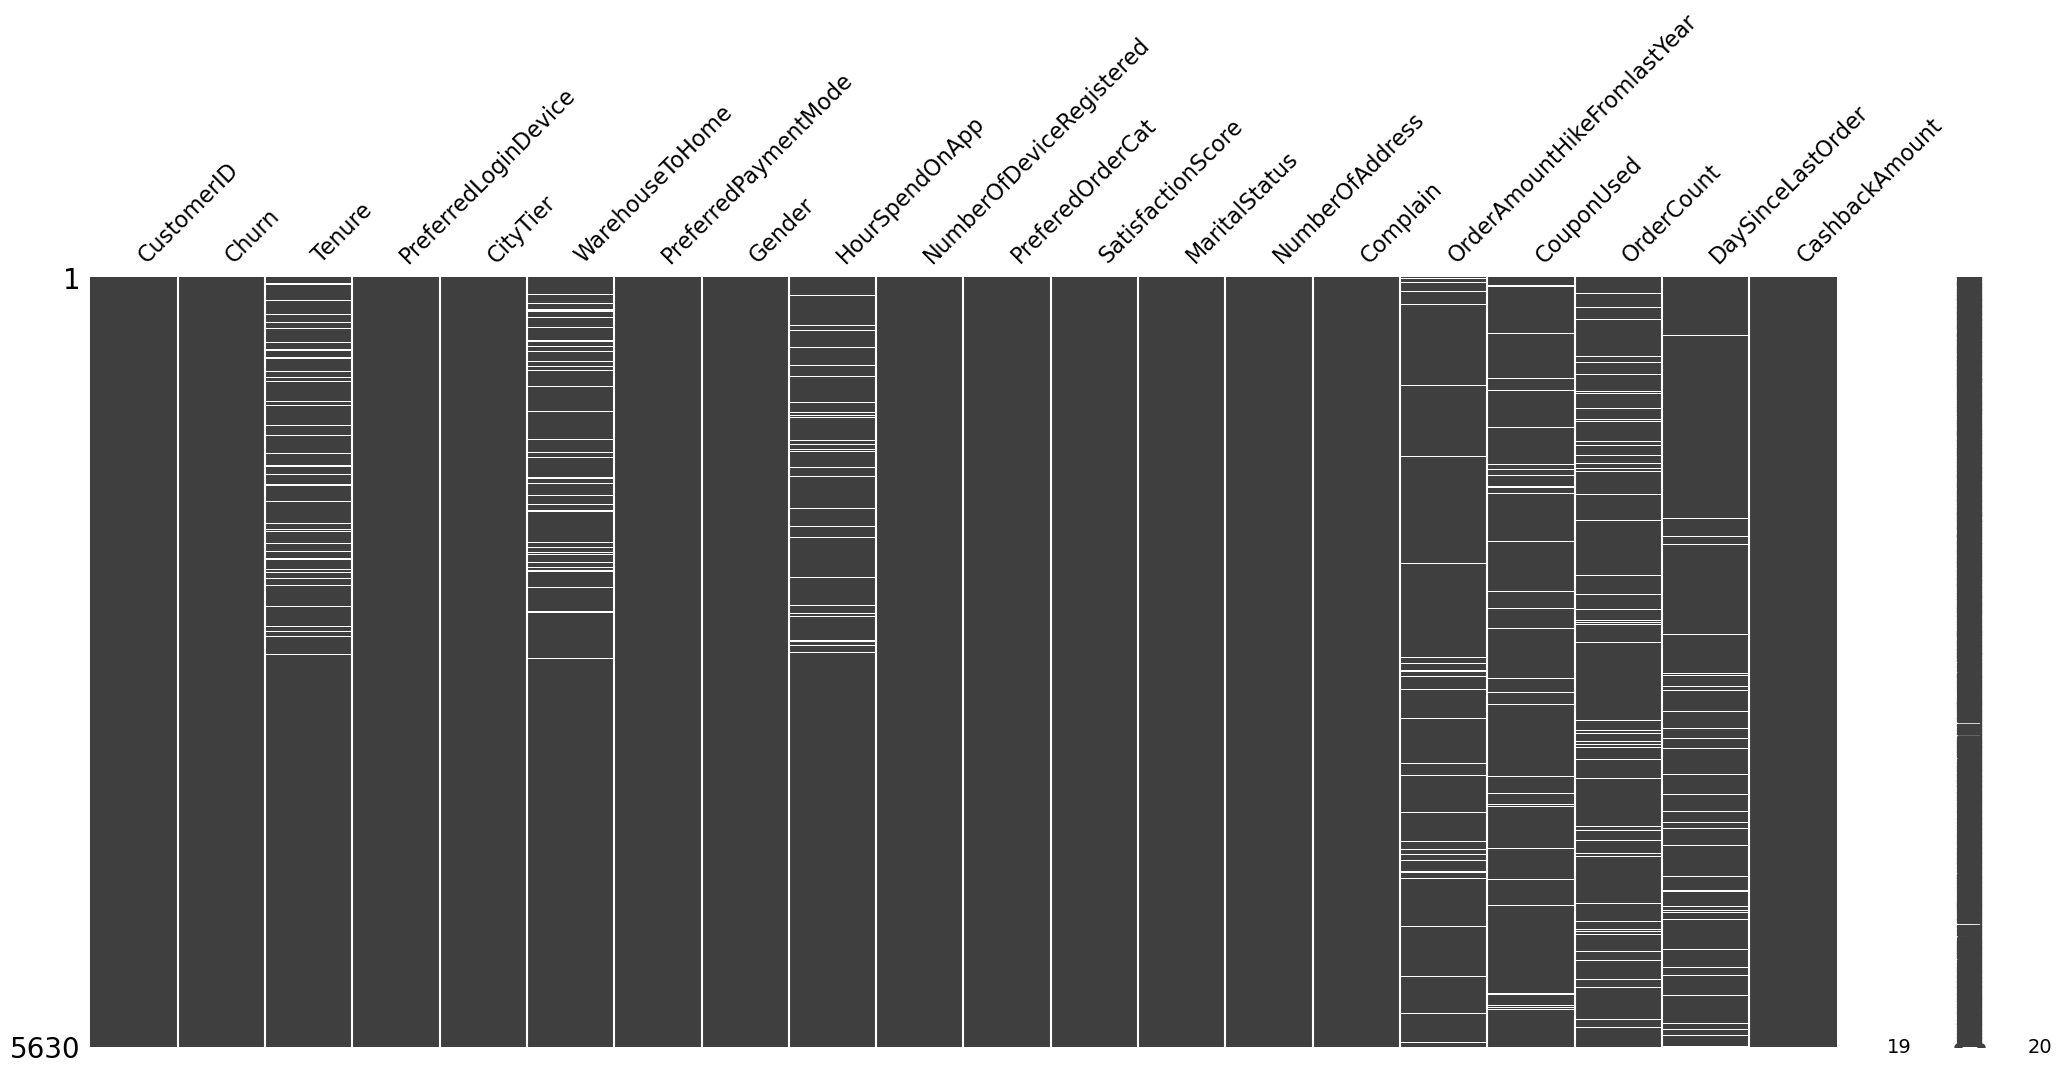

In [482]:
msno.matrix(df)


All missing values in columns less than 6% 

Because tenure is related to time data, i use bfill method to fill, i think records which are close to each other should be quite similar.

In [483]:
df['Tenure'] = df['Tenure'].fillna(method = 'bfill')

WarehouseToHome has skewed distribution, so I use most-frequent data to fill.

In [484]:
# Impute with simple imputer
from sklearn.impute import SimpleImputer
s_imp = SimpleImputer(missing_values=np.nan , strategy = 'most_frequent')
df['WarehouseToHome'] = s_imp.fit_transform(pd.DataFrame(df['WarehouseToHome']))

Because in HourSpendOnApp, there are integer values so I use random fill to keep integers.

In [485]:
fill_list = df['HourSpendOnApp'].dropna()
df['HourSpendOnApp'] = df['HourSpendOnApp'].fillna(pd.Series(np.random.choice(fill_list , size = len(df['HourSpendOnApp'].index))))

In AmountHikeFromlastYear, according to its distribution, use ffill method.

In [486]:
# impute with ffill method
df['OrderAmountHikeFromlastYear'] = df['OrderAmountHikeFromlastYear'].fillna(method = 'ffill')

In CouponUsed, use KNNImputer for numeric data to preserve the complexity of data.

In [487]:
# Impute with KNN Imputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
df['CouponUsed']=imputer.fit_transform(df[['CouponUsed']])

In [488]:
# Impute with KNN imputer
imputer_2 = KNNImputer(n_neighbors=2)
df['OrderCount']=imputer_2.fit_transform(df[['OrderCount']])

In [489]:
df['DaySinceLastOrder'] = df['DaySinceLastOrder'].fillna(method = 'bfill')

#### Check for duplicated values

In [490]:
df.duplicated().any()

False

#### Check for correlation

In [491]:
df.drop('CustomerID' , axis = 1 , inplace = True)

In [492]:
df2=df.copy()

In [493]:
# Encode for cat_cols
le = LabelEncoder()
for i in df2.columns:
  if df2[i].dtype == 'object':
    df2[i] = le.fit_transform(df[i])

df.head(4)

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,1,0.0,Mobile Phone,1,8.0,UPI,Male,3.0,4,Mobile Phone,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,1,0.0,Mobile Phone,1,30.0,Debit Card,Male,2.0,4,Mobile Phone,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,1,0.0,Mobile Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07


In [494]:
df2.shape

(5630, 19)

In [495]:
corr_matrix = df2.corr()
corr_matrix

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
Churn,1.000000,-0.337423,-0.051099,0.084703,0.056958,0.002345,0.029264,0.017965,0.107939,0.104569,0.105481,0.140316,0.043931,0.250188,-0.003334,-0.008197,-0.028342,-0.151667,-0.154118
Tenure,-0.337423,1.000000,0.036572,-0.058863,-0.000057,-0.020023,-0.043973,-0.018238,-0.021414,-0.182954,-0.014246,-0.107168,0.222450,-0.019536,0.014328,0.117747,0.173686,0.168380,0.452192
PreferredLoginDevice,-0.051099,0.036572,1.000000,0.002476,-0.022050,0.006681,-0.015871,0.020936,-0.021096,0.005152,0.036049,-0.028785,0.025863,0.001327,-0.011559,-0.010495,-0.015756,0.002126,0.047885
CityTier,0.084703,-0.058863,0.002476,1.000000,0.022861,0.246170,-0.025176,-0.008876,0.027934,-0.170513,-0.011554,0.006818,-0.029440,0.003375,-0.024515,0.021009,0.032625,0.022017,0.055746
WarehouseToHome,0.056958,-0.000057,-0.022050,0.022861,1.000000,0.015127,-0.001917,0.080084,0.035969,-0.100046,0.007413,-0.018447,-0.000768,0.023118,0.024585,0.011602,0.017553,0.035983,0.028592
PreferredPaymentMode,0.002345,-0.020023,0.006681,0.246170,0.015127,1.000000,0.016999,-0.009756,0.015938,-0.032268,-0.014640,-0.021391,-0.004544,0.023890,-0.000405,-0.001081,-0.032870,0.006783,0.037329
Gender,0.029264,-0.043973,-0.015871,-0.025176,-0.001917,0.016999,1.000000,-0.016157,-0.021799,0.062003,-0.035220,-0.017370,-0.031492,-0.040269,0.001181,-0.037642,-0.030581,-0.021026,-0.025190
HourSpendOnApp,0.017965,-0.018238,0.020936,-0.008876,0.080084,-0.009756,-0.016157,1.000000,0.298099,0.034954,0.032123,-0.043546,0.142312,0.009942,0.100794,0.179668,0.102931,0.069796,0.117924
NumberOfDeviceRegistered,0.107939,-0.021414,-0.021096,0.027934,0.035969,0.015938,-0.021799,0.298099,1.000000,-0.011239,-0.017228,0.033645,0.084997,0.003407,0.070943,0.148638,0.100316,0.027165,0.137183
PreferedOrderCat,0.104569,-0.182954,0.005152,-0.170513,-0.100046,-0.032268,0.062003,0.034954,-0.011239,1.000000,-0.003803,0.042845,-0.085969,-0.007004,-0.000467,-0.146088,-0.168818,-0.214489,-0.332180


<AxesSubplot:>

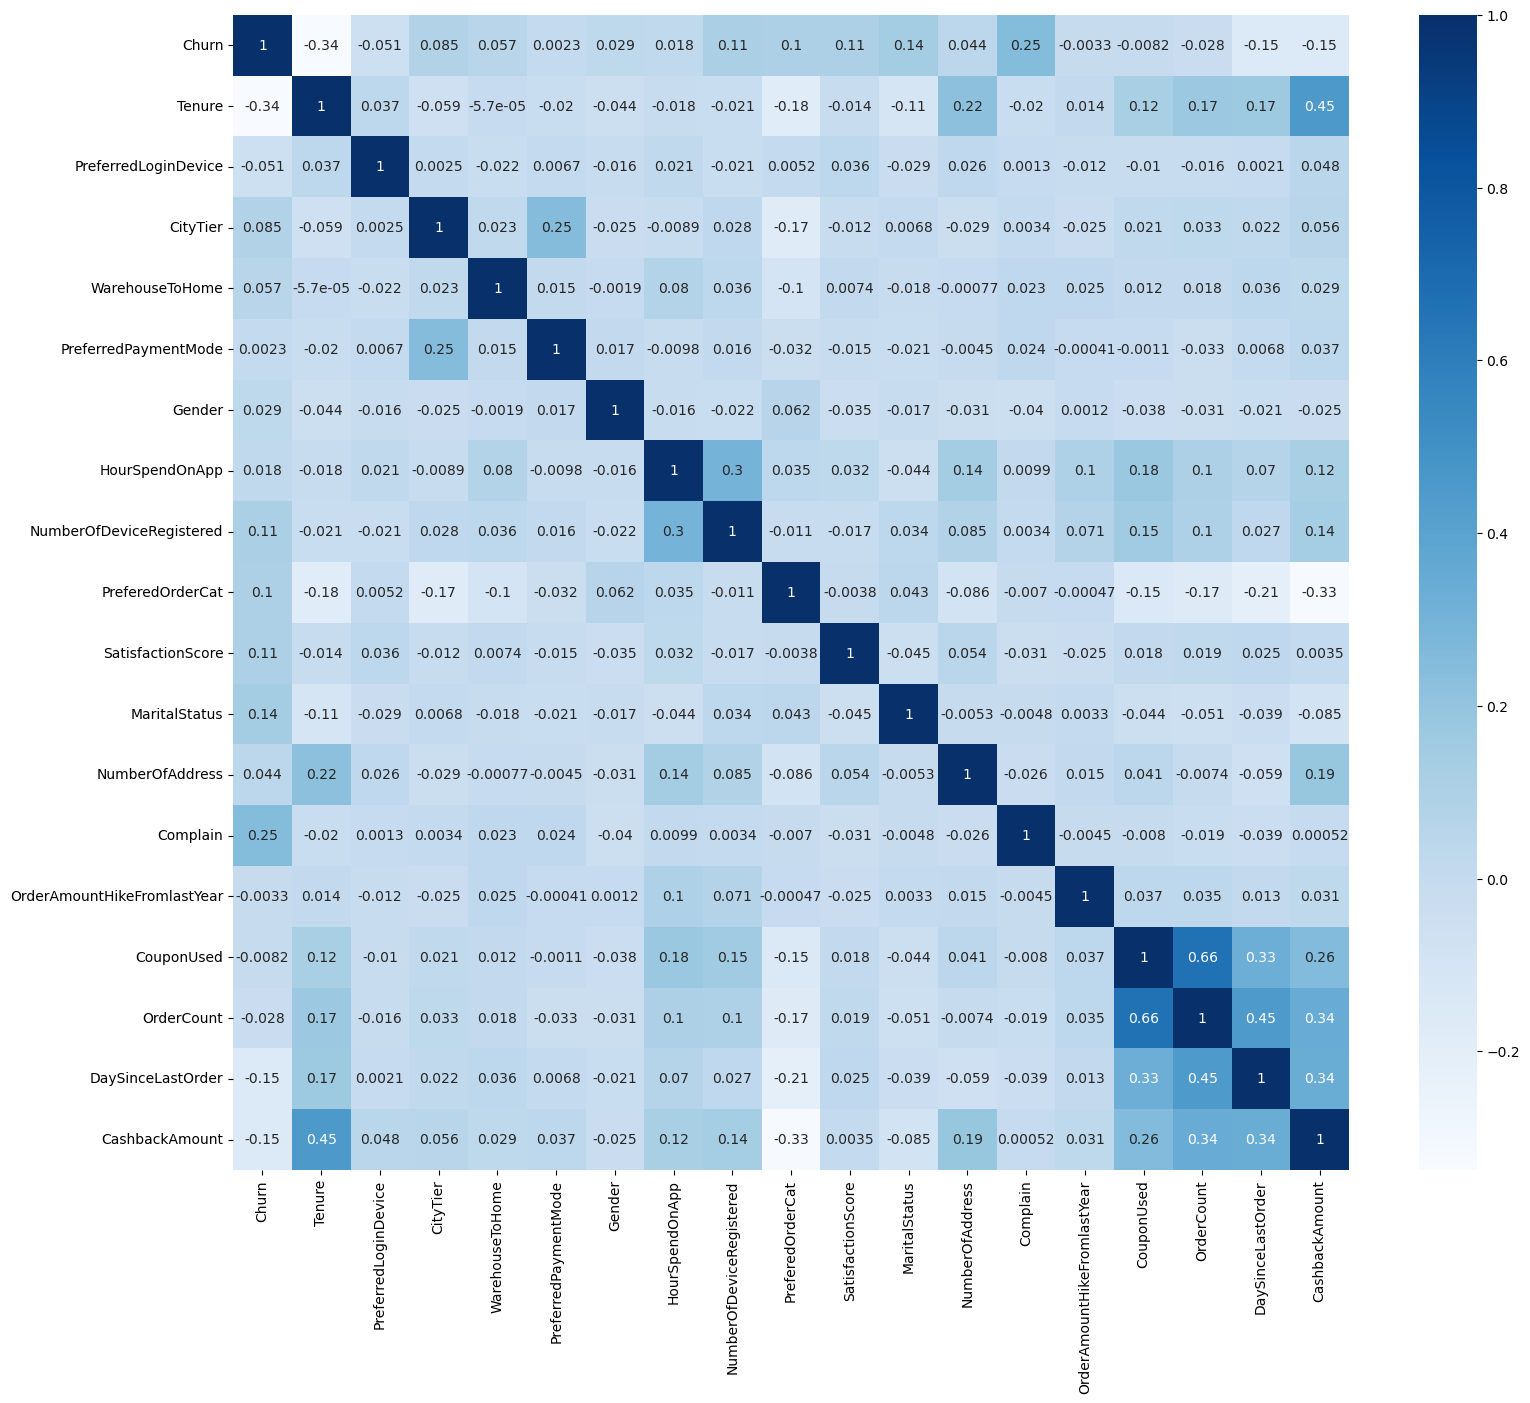

In [496]:
plt.figure(figsize = (18,15))
sns.heatmap(df2.corr() , annot = True , cmap = 'Blues')

In [497]:
churn_corr_vector = corr_matrix['Churn'].sort_values(ascending = False)
churn_corr_vector

Churn                          1.000000
Complain                       0.250188
MaritalStatus                  0.140316
NumberOfDeviceRegistered       0.107939
SatisfactionScore              0.105481
PreferedOrderCat               0.104569
CityTier                       0.084703
WarehouseToHome                0.056958
NumberOfAddress                0.043931
Gender                         0.029264
HourSpendOnApp                 0.017965
PreferredPaymentMode           0.002345
OrderAmountHikeFromlastYear   -0.003334
CouponUsed                    -0.008197
OrderCount                    -0.028342
PreferredLoginDevice          -0.051099
DaySinceLastOrder             -0.151667
CashbackAmount                -0.154118
Tenure                        -0.337423
Name: Churn, dtype: float64

Text(0.5, 1.0, 'Relation Between Features and target')

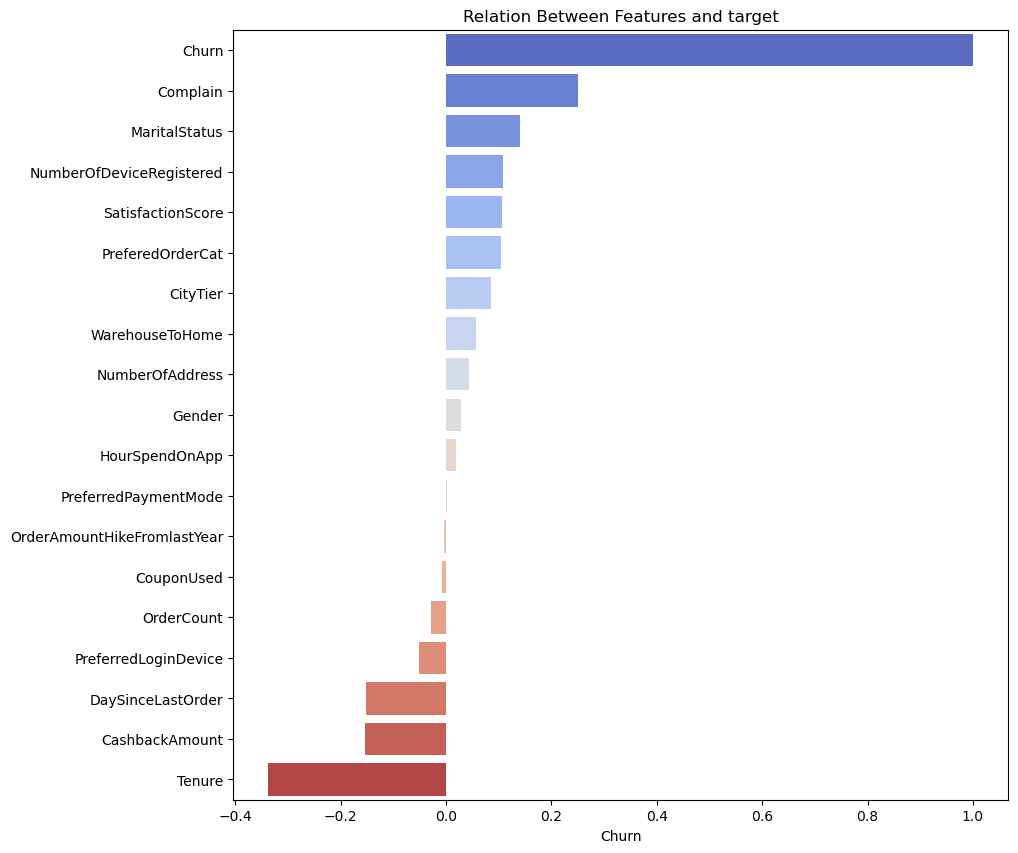

In [498]:
plt.figure(figsize = (10,10))
sns.barplot(x = churn_corr_vector , y = churn_corr_vector.index , palette = 'coolwarm')
plt.title('Relation Between Features and target')

## Feature transforming

Based on correlation plot, CustomerID, OrderAmountHikeFromLastYear, CityTier, HourSpendOnApp, NumberOfAddress, OrderCount, PreferredLoginDevice, PreferredPaymentMode, Gender should be removed.

### Encoding

In [499]:
df=pd.get_dummies(df,columns=['PreferedOrderCat','MaritalStatus','PreferredPaymentMode','Gender','PreferredLoginDevice'])

### Handling Imbalanced Data

In [500]:
X = df.drop('Churn' , axis = 1)
Y = df['Churn']
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42)
x_over , y_over = smt.fit_resample(X , Y)
x_over.shape, y_over.shape

((9364, 30), (9364,))

### Split data

In [501]:
x_train , x_test , y_train , y_test = train_test_split(x_over , y_over , test_size = 0.30 , random_state = 42)

### Normalization


In [502]:
from sklearn.preprocessing import MinMaxScaler
MM=MinMaxScaler()
x_train_scaled=MM.fit_transform(x_train)
x_test_scaled=MM.fit_transform(x_test)


## Model Selection - Model Training

### Apply model Logistic Regression

In [503]:
train_acc_list=[]
test_acc_list=[]
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
logreg.fit(x_train_scaled,y_train)

LogisticRegression()

In [504]:
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score

y_train_predict=logreg.predict(x_train_scaled)
y_test_predict=logreg.predict(x_test_scaled)
train_acc_list.append(balanced_accuracy_score(y_train, y_train_predict))
test_acc_list.append(balanced_accuracy_score(y_test, y_test_predict))

print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_train_predict)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_test_predict)}')

Balance accuracy of train set: 0.908876743423537
Balance accuracy of test set: 0.8907332742657201


### Apply model DecisionTree

In [505]:
from sklearn import tree

# Fit model into train set:
clf_des = tree.DecisionTreeClassifier()
clf_des.fit(x_train_scaled,y_train)

# Apply model on train set and test set: 
y_tree_pre_train = clf_des.predict(x_train_scaled)
y_tree_pre_test = clf_des.predict(x_test_scaled)
train_acc_list.append(balanced_accuracy_score(y_train, y_tree_pre_train))
test_acc_list.append(balanced_accuracy_score(y_test, y_tree_pre_test))

# Calculate the balanced accuracy on train set and test set to check overfiting and underfiting: 
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_tree_pre_train)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_tree_pre_test)}')

Balance accuracy of train set: 1.0
Balance accuracy of test set: 0.8451995406302606


### Apply model RandomForest

In [506]:
from sklearn.ensemble import RandomForestClassifier

# Fit model into train set:
clf_rand = RandomForestClassifier()
clf_rand.fit(x_train_scaled, y_train)


# Apply model on train set and test set: 
y_ranf_pre_train = clf_rand.predict(x_train_scaled)
y_ranf_pre_test = clf_rand.predict(x_test_scaled)
train_acc_list.append(balanced_accuracy_score(y_train, y_ranf_pre_train))
test_acc_list.append(balanced_accuracy_score(y_test, y_ranf_pre_test))

# Calculate the balanced accuracy on train set and test set to check overfiting and underfiting: 
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_ranf_pre_train)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_ranf_pre_test)}')

Balance accuracy of train set: 1.0
Balance accuracy of test set: 0.9491028156406582


In [507]:
clf_name_list = ['Logistic Regression','Decision Tree', 'Random Forest']
all_models = pd.DataFrame({'Train_Accuarcy': train_acc_list , 'Test_Accuarcy' : test_acc_list}  , index = clf_name_list)
all_models


,Train_Accuarcy,Test_Accuarcy
Logistic Regression,0.908877,0.890733
Decision Tree,1.000000,0.845200
Random Forest,1.000000,0.949103


## Evaluation

ROC Area under Curve = 0.8907332742657202
              precision    recall  f1-score   support

           0    0.89409   0.88580   0.88992      1401
           1    0.88748   0.89567   0.89156      1409

    accuracy                        0.89075      2810
   macro avg    0.89079   0.89073   0.89074      2810
weighted avg    0.89078   0.89075   0.89074      2810



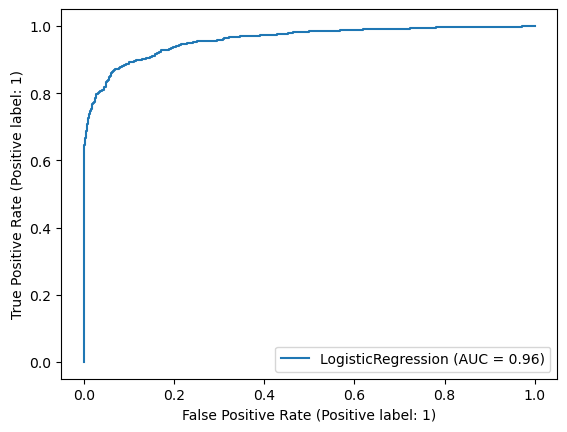

In [508]:
#Linear Regression
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay
model= LogisticRegression()
model.fit(x_train_scaled,y_train)
y_pred = model.predict(x_test_scaled)
roc_auc1 = roc_auc_score(y_test, y_pred)
print("ROC Area under Curve = {}".format(roc_auc1))
print(classification_report(y_test,y_pred,digits=5))
RocCurveDisplay.from_estimator(model , x_test_scaled , y_test)

ROC Area under Curve = 0.8434049692782557
              precision    recall  f1-score   support

           0    0.84543   0.83940   0.84241      1401
           1    0.84144   0.84741   0.84441      1409

    accuracy                        0.84342      2810
   macro avg    0.84344   0.84340   0.84341      2810
weighted avg    0.84343   0.84342   0.84341      2810



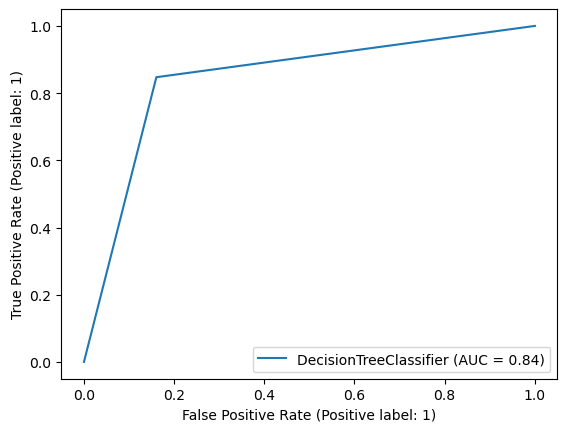

In [509]:
##tree
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay
model= tree.DecisionTreeClassifier()
model.fit(x_train_scaled,y_train)
y_pred = model.predict(x_test_scaled)
roc_auc1 = roc_auc_score(y_test, y_pred)
print("ROC Area under Curve = {}".format(roc_auc1))
print(classification_report(y_test,y_pred,digits=5))
RocCurveDisplay.from_estimator(model , x_test_scaled , y_test)

0.9576357048017512
ROC Area under Curve = 0.9576357048017513
              precision    recall  f1-score   support

           0    0.96248   0.95218   0.95730      1401
           1    0.95295   0.96309   0.95800      1409

    accuracy                        0.95765      2810
   macro avg    0.95772   0.95764   0.95765      2810
weighted avg    0.95770   0.95765   0.95765      2810



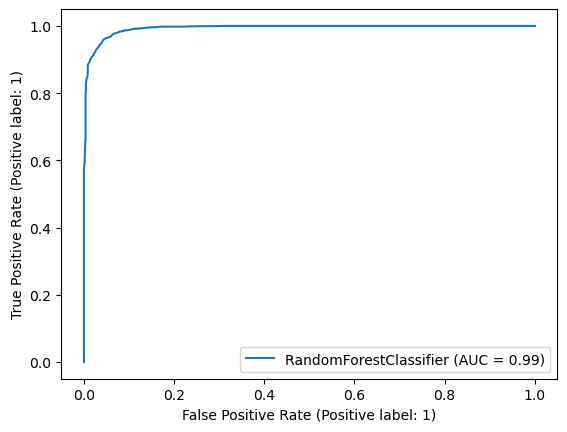

In [510]:
#RandomForest
model= RandomForestClassifier()
model.fit(x_train_scaled,y_train)
y_pred = model.predict(x_test_scaled)
roc_auc1 = roc_auc_score(y_test, y_pred)
print(balanced_accuracy_score(y_test,y_pred))
print("ROC Area under Curve = {}".format(roc_auc1))
print(classification_report(y_test,y_pred,digits=5))
RocCurveDisplay.from_estimator(model , x_test_scaled , y_test)

Based on evaluation, I will choose RandomForest to deploy.

In [511]:
# feats = {} # a dict to hold feature_name: feature_importance

# for feature, importance in zip(x_test.columns, clf_rand.feature_importances_):
#     feats[feature] = importance #add the name/value pair 

# importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
# importances = importances.sort_values(by='Gini-importance', ascending=True)

# importances = importances.reset_index()


In [512]:
# # Create bar chart
# plt.figure(figsize=(10, 10))
# plt.barh(importances.tail(20)['index'][:20], importances.tail(20)['Gini-importance'])

# plt.title('Feature Important')

# # Show plot
# plt.show()

In [513]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid = {
#     'penalty': ['l1','l2'],
#     'tol' : [0.01,0.001,0.0001],
#     'max_iter' : [100,150,200],
#     'solver' :['lbfgs','liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
# }

# # Use GridSearchCV to find the best parameters
# grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='balanced_accuracy')

# # Fit the model
# grid_search.fit(x_train_scaled, y_train)

# # Print the best parameters
# print("Best Parameters: ", grid_search.best_params_)

# # Evaluate the best model on the test set
# best_clf = grid_search.best_estimator_
# accuracy = best_clf.score(x_test_scaled, y_test)
# print("Test set accuracy: ", accuracy)

In [514]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [10, 50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# # Use GridSearchCV to find the best parameters
# grid_search = GridSearchCV(clf_rand, param_grid, cv=5, scoring='balanced_accuracy')

# # Fit the model
# grid_search.fit(x_train_scaled, y_train)

# # Print the best parameters
# print("Best Parameters: ", grid_search.best_params_)

# # Evaluate the best model on the test set
# best_clf = grid_search.best_estimator_
# accuracy = best_clf.score(x_test_scaled, y_test)
# print("Test set accuracy: ", accuracy)